# Refinando o Modelo de Regressão - Features Polinomiais

Nesse Notebook, foi realizado o refino do modelo testando grandezas de segundo e terceiro grau nas variáveis de entrada.

Regressor: Linear

Graus dos polinomios - 1, 2 e 3

Todo o processo desenvolvido na etapa anterior foi repetida.



# Importar Bibliotecas e dados

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 17564 non-null  float32
 1   latitude                  17564 non-null  float32
 2   housing_median_age        17564 non-null  int8   
 3   total_rooms               17564 non-null  int16  
 4   total_bedrooms            17564 non-null  int16  
 5   population                17564 non-null  int16  
 6   households                17564 non-null  int16  
 7   median_income             17564 non-null  float32
 8   median_house_value        17564 non-null  int32  
 9   ocean_proximity           17564 non-null  object 
 10  median_income_cat         17564 non-null  int64  
 11  rooms_per_household       17564 non-null  float32
 12  population_per_household  17564 non-null  float32
 13  bedrooms_per_room         17564 non-null  float32
dtypes: flo

In [4]:
df['ocean_proximity'] = df['ocean_proximity'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

# Definição dos Modelos

In [5]:
coluna_target = ['median_house_value']

coluna_one_hot_encoder = ['ocean_proximity']

coluna_ordinal_encoder = ['median_income_cat']

In [6]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [7]:
pipeline_robust = Pipeline(steps=[
    ("robust_scaler", RobustScaler()),
    ("poly", PolynomialFeatures(degree=1, include_bias=False))
])

preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot_encoder", OneHotEncoder(drop='first'), coluna_one_hot_encoder),
        ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler) # Std menos sensível a outliers
    ],
    remainder='passthrough'
)

In [8]:
X = df.drop(columns=coluna_target)

y = df[coluna_target]

# Encontrando o melhor Modelo

In [9]:
param_grid = { 
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3],
}

In [10]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution='normal'),
    param_grid=param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pip...
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [11]:
grid_search.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pip...
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [12]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3}

Grau 3 apresentou o menor erro, vamos avaliar agora os scores e os principais coefientes

In [13]:
grid_search.best_score_

np.float64(-51145.84344886369)

In [14]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

coefs

,coeficiente
robust_scaler_poly__longitude total_rooms,-313924.292082
robust_scaler_poly__housing_median_age total_rooms,-227347.580379
robust_scaler_poly__latitude total_rooms,-217657.998778
robust_scaler_poly__rooms_per_household total_bedrooms,-214517.420832
robust_scaler_poly__latitude population_per_household total_rooms,-208340.625630
...,...
robust_scaler_poly__households,163652.143638
robust_scaler_poly__longitude population,170453.655311
robust_scaler_poly__latitude population rooms_per_household,209693.842518
robust_scaler_poly__bedrooms_per_room households,220478.504411


São 367 coeficientes diferentes, vamos olhar apenas os abaixo de -100.000 e acima de 100.000 - escala aumentou muito por ter relação de 3º grau

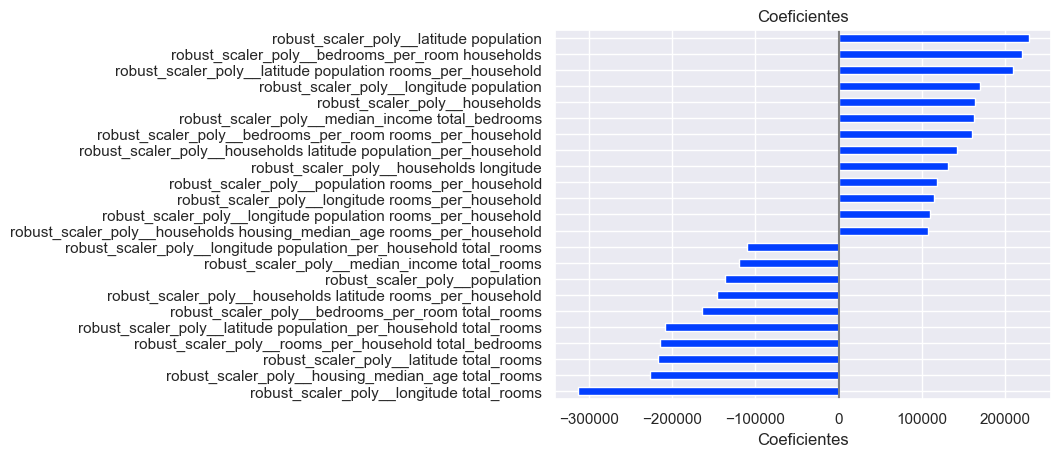

In [ ]:
# somente os coeficientes mais relevantes
plot_coeficientes(coefs[~coefs['coeficiente'].between(-100_000,100_000)])

Agora temos variáveis compostas influenciando o modelo, sendo as de maiores coeficientes a de latitude com população e longitude com maior número de quartos. Essas relações, apesar de mais dificeis de compreender, permitem mais opções de refino por parte do modelo.

# Comparando o Melhor Modelo com referência

In [ ]:
regressors = {
    "DummyRegressor" : {
        "preprocessor" : None,
        "regressor" : DummyRegressor(strategy='mean'),
        "target_transformer" : None,
    },
        "LinearRegression" : {
        "preprocessor" : preprocessamento,
        "regressor" : LinearRegression(),
        "target_transformer" : None,
    },
        "LinearRegression_target_quantile" : {
        "preprocessor" : preprocessamento,
        "regressor" : LinearRegression(),
        "target_transformer" : QuantileTransformer(output_distribution='normal'),
    },
        "LinearRegression_poly" : {
        "preprocessor" : grid_search.best_estimator_.regressor_['preprocessor'],
        "regressor" : grid_search.best_estimator_.regressor_['reg'],
        "target_transformer" : grid_search.best_estimator_.transformer_,
    },

}

resultados = {
    nome_modelo : treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.002991,0.004,-0.000081,-77516.042766,-96239.705692,0.006991
1,DummyRegressor,0.003002,0.002998,-0.000146,-75787.787194,-95217.629397,0.006
2,DummyRegressor,0.003002,0.003,-0.001737,-76753.598961,-96253.253947,0.006002
3,DummyRegressor,0.001998,0.002006,-0.000101,-76837.804811,-95983.885799,0.004004
4,DummyRegressor,0.002001,0.002007,-0.000114,-76617.245449,-96182.764729,0.004007
5,LinearRegression,0.023995,0.008004,0.682162,-39855.690996,-54254.958188,0.031998
6,LinearRegression,0.024997,0.008002,0.66999,-40272.565467,-54695.230283,0.032999
7,LinearRegression,0.024006,0.007001,0.649247,-42178.05929,-56955.988706,0.031007
8,LinearRegression,0.022005,0.007001,0.669873,-40806.492497,-55146.318803,0.029006
9,LinearRegression,0.022008,0.006999,0.669023,-40788.496497,-55331.35106,0.029007


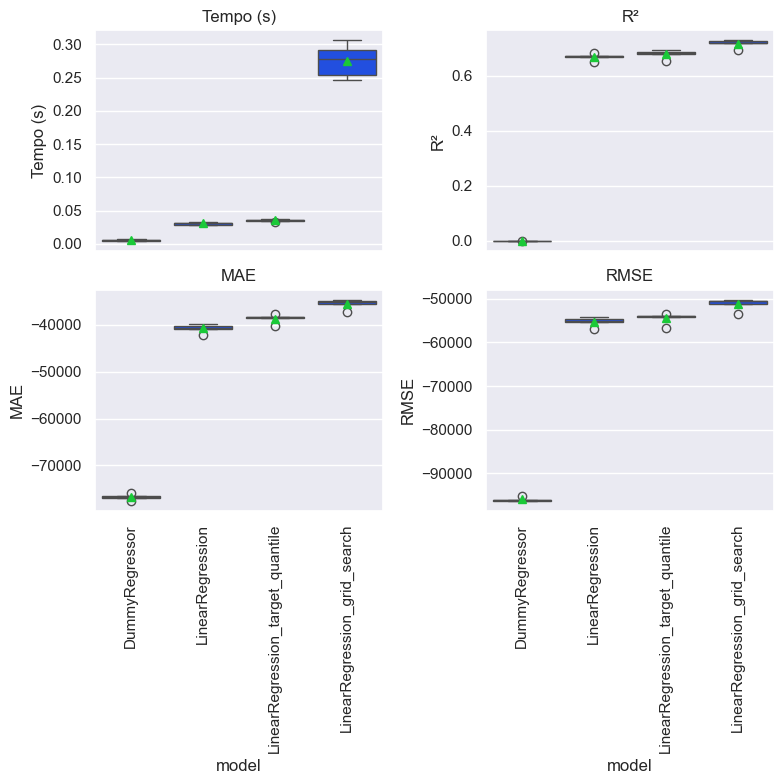

In [25]:
plot_comparar_metricas_modelos(df_resultados)

Tivemos um aumento considerável no tempo de processamento (fit e score), porém ainda é um tempo baixo (0.28s em relação a 0.04s), com diminuição no erro. Ainda vamos tentar refinar mais a questão do erro.

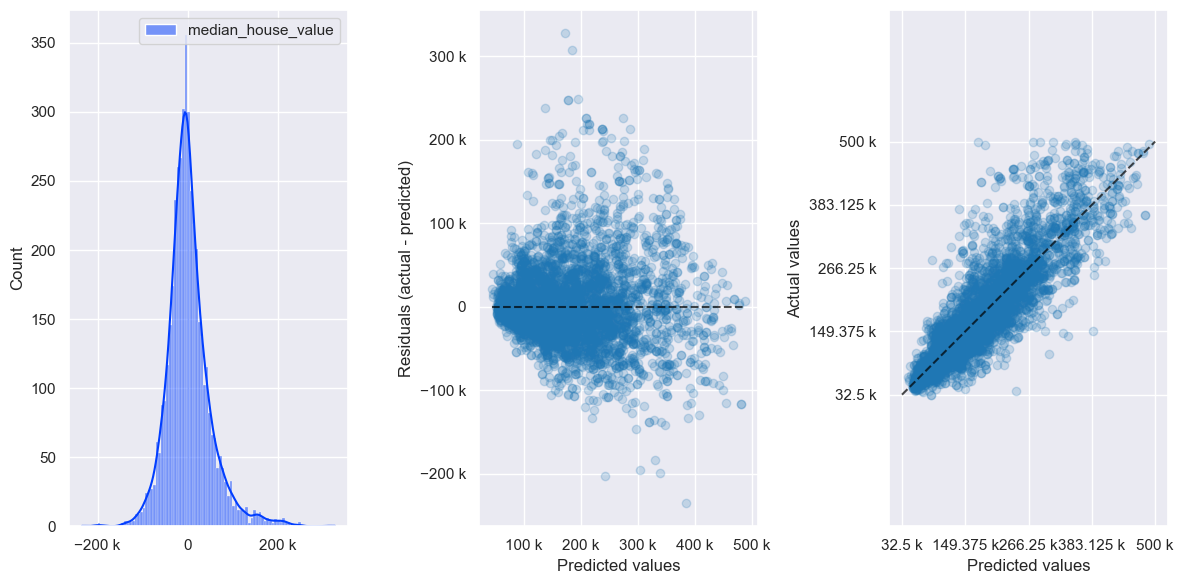

In [ ]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, eng_formatter=True)

A maior frequência de resíduo próximo a zero nos testes mostra a eficácia do modelo. Os erros maiores ocorrem para casas mais caras, com erro para menos (valor real maior que o previsto para os maiores erros). Isso acontece pois temos mais registros na base com casas de menor a médio preço do que de preços exorbitantes, como é possível notar nos 2 gráficos a direita.

Comparando com o resultado anterior, não foi possível observar melhora